# Correlation 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('dataset/illness/national_illness_24_4.csv')
df.columns = ['date','ILITOTAL','Num providers','Num visits','Num hospitalizations','Num vaccinations']

In [6]:
df

,date,ILITOTAL,NUM. OF PROVIDERS,OT,h,c
0,8/12/2019,8987,2178,1076513,0,128151
1,8/19/2019,10096,2147,1071703,0,281834
2,8/26/2019,11817,2169,1095230,0,534607
3,9/2/2019,13158,2189,1090741,0,873607
4,9/9/2019,14831,2221,1162580,0,1393826
...,...,...,...,...,...,...
257,7/15/2024,33474,3859,2336121,34,0
258,7/22/2024,34749,3887,2307921,26,0
259,7/29/2024,34935,3889,2334775,18,0
260,8/5/2024,34912,3839,2312831,32,169924


In [11]:
# df.columns

# columns = df.columns[1:]

# matrix = df[columns]
# matrix

In [26]:

columns = df.columns[1:]

def plot_corr(dframe):
    # Compute the correlation matrix
    matrix = dframe.corr()

    # Plotting the correlation matrix
    plt.figure(figsize=(5, 4))  # Optional: adjust the figure size
    plt.imshow(matrix, cmap='coolwarm', vmin=-1, vmax=1)

    # Add colorbar
    plt.colorbar()

    # Extract variable names
    variables = matrix.columns.tolist()

    # Add axis labels
    plt.xticks(range(len(variables)), variables, rotation=45, ha='right')
    plt.yticks(range(len(variables)), variables)

    # Annotate correlation values
    for i in range(len(variables)):
        for j in range(len(variables)):
            plt.text(j, i, f'{matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

    # Display the plot
    plt.tight_layout()
    plt.show()

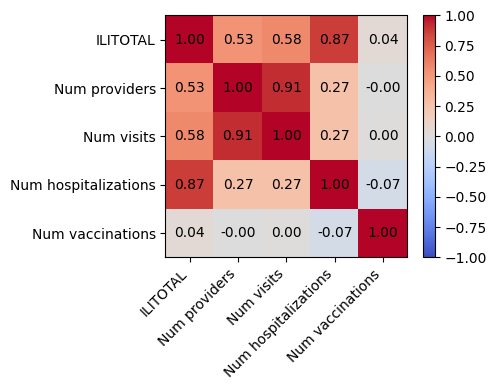

In [27]:
plot_corr(df[columns])

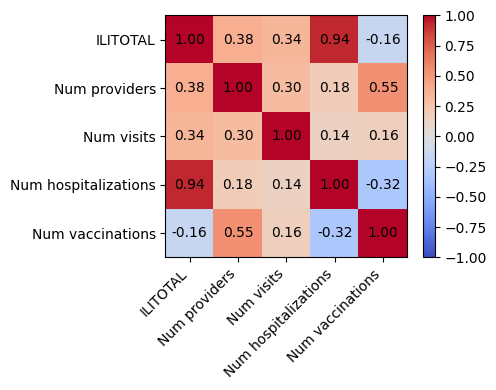

In [34]:
plot_corr(df[columns][216:251])

In [23]:
matrix

,ILITOTAL,Num providers,Num visits,Num hospitalizations,Num vaccinations
ILITOTAL,1.000000,0.528150,0.576028,0.869600,0.039325
Num providers,0.528150,1.000000,0.914672,0.268401,-0.002162
Num visits,0.576028,0.914672,1.000000,0.268944,0.003296
Num hospitalizations,0.869600,0.268401,0.268944,1.000000,-0.066452
Num vaccinations,0.039325,-0.002162,0.003296,-0.066452,1.000000


# Cosine similarity

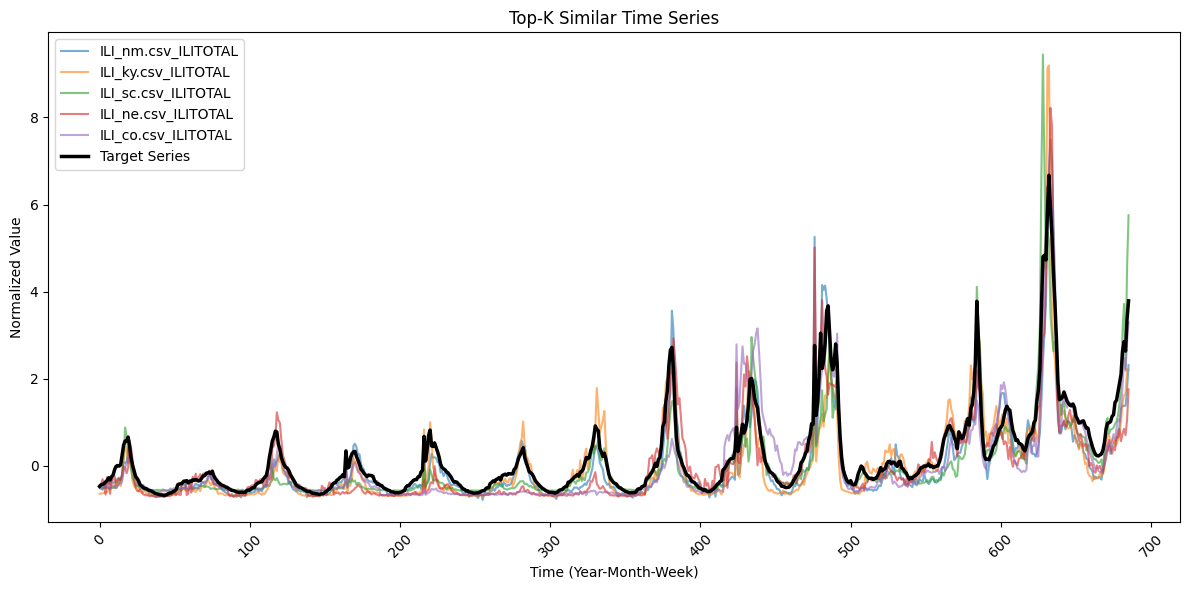

ILI_nm.csv_ILITOTAL: 0.9096
ILI_ky.csv_ILITOTAL: 0.8991
ILI_sc.csv_ILITOTAL: 0.8873
ILI_ne.csv_ILITOTAL: 0.8768
ILI_co.csv_ILITOTAL: 0.8725


In [65]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import os

def load_and_process_timeseries(folder_path, exclude_files=[]):
    series_dict = {}

    for file in os.listdir(folder_path):
        if file.endswith('.csv') and file not in exclude_files:
            df = pd.read_csv(os.path.join(folder_path, file))
            df['date'] = pd.to_datetime(df.iloc[:, 0])
            df.set_index('date', inplace=True)
            df.dropna(axis=1, how='any', inplace=True)

            # Group by year, month, ISO week number
            df['year'] = df.index.year
            df['month'] = df.index.month
            df['week'] = df.index.isocalendar().week
            grouped = df.groupby(['year', 'month', 'week']).mean()

            # Normalize each column
            for col in grouped.columns:
                norm = (grouped[col] - grouped[col].mean()) / grouped[col].std()
                series_dict[f"{file}_{col}"] = norm

    return series_dict

def load_target_series(target_file,target_column):
    df = pd.read_csv(target_file)
    df['date'] = pd.to_datetime(df.iloc[:, 0])
    df.set_index('date', inplace=True)
    df.dropna(axis=1, how='any', inplace=True)

    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    grouped = df.groupby(['year', 'month', 'week']).mean()

    # Assume only one column after date
    col = target_column #grouped.columns[0]
    norm = (grouped[col] - grouped[col].mean()) / grouped[col].std()
    return norm

def get_top_k_similar(series_dict, target_series, k=5):
    similarities = {}

    for name, series in series_dict.items():
        common_idx = target_series.index.intersection(series.index)
#         print("common_idx",common_idx)
        if len(common_idx) > 2:
            sim = cosine_similarity(
                target_series.loc[common_idx].values.reshape(1, -1),
                series.loc[common_idx].values.reshape(1, -1)
            )[0][0]
            similarities[name] = sim

    top_k = sorted(similarities.items(), key=lambda x: -x[1])[:k]
    return top_k

# Example usage:



folder = './dataset/illness'
target_path = './dataset/illness/national_illness_24.csv'
target_column = 'ILITOTAL'
exclude = ['national_illness_24.csv','national_illness.csv','national_illness_24_2.csv','national_illness_24_3.csv','national_illness_24_3cols.csv','national_illness_24_4.csv','national_illness_3cols.csv']


series_dict = load_and_process_timeseries(folder, exclude)
target_series = load_target_series(target_path,target_column)
top_k = get_top_k_similar(series_dict, target_series, k=5)
# top_k = get_top_k_similar(series_dict, target_series, k=5)
plot_top_k_series(series_dict, target_series, top_k)
for name, sim in top_k:
    print(f"{name}: {sim:.4f}")


In [38]:
# top_k

In [61]:
import matplotlib.pyplot as plt

def plot_top_k_series(series_dict, target_series, top_k, title="Top-K Similar Time Series"):
    plt.figure(figsize=(12, 6))

    # Plot each of the top-k similar time series
    for name, _ in top_k:
        series = series_dict[name]

        # Align based on intersection of year-month-week index
        common_idx = target_series.index.intersection(series.index)

        if not common_idx.empty:
            plt.plot(range(len(common_idx)), series.loc[common_idx].values.flatten(), label=f"{name}", alpha=0.6)

    # Plot target series
    plt.plot(range(len(common_idx)), target_series.loc[common_idx].values.flatten(), label="Target Series", linewidth=2.5, color='black')

    plt.title(title)
    plt.xlabel("Time (Year-Month-Week)")
    plt.ylabel("Normalized Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
#     plt.grid(True)
    plt.show()
    


In [7]:
!ls ./dataset/illness


ILI_ak.csv  ILI_il.csv	ILI_mt.csv   ILI_or.csv  ILI_wa.csv
ILI_al.csv  ILI_in.csv	ILI_nc.csv   ILI_pa.csv  ILI_wi.csv
ILI_ar.csv  ILI_ks.csv	ILI_nd.csv   ILI_pr.csv  ILI_wv.csv
ILI_az.csv  ILI_ky.csv	ILI_ne.csv   ILI_ri.csv  ILI_wy.csv
ILI_ca.csv  ILI_la.csv	ILI_nh.csv   ILI_sc.csv  national_illness.csv
ILI_co.csv  ILI_ma.csv	ILI_nj.csv   ILI_sd.csv  national_illness_24.csv
ILI_ct.csv  ILI_md.csv	ILI_nm.csv   ILI_tn.csv  national_illness_24_2.csv
ILI_de.csv  ILI_me.csv	ILI_nv.csv   ILI_tx.csv  national_illness_24_3.csv
ILI_ga.csv  ILI_mi.csv	ILI_ny.csv   ILI_ut.csv  national_illness_24_3cols.csv
ILI_hi.csv  ILI_mn.csv	ILI_nyc.csv  ILI_va.csv  national_illness_24_4.csv
ILI_ia.csv  ILI_mo.csv	ILI_oh.csv   ILI_vi.csv  national_illness_3cols.csv
ILI_id.csv  ILI_ms.csv	ILI_ok.csv   ILI_vt.csv
